# Multiple Instance Learning with Graph Neural Networks
### `IABI Course, Dr. Rohban`
#### Homework 1
*`Full Name:`* Farzan Rahmani

*`SID:`* 403210725

## Proposed Method Description

In this notebook, we explore **Multiple Instance Learning (MIL)** by leveraging **Graph Neural Networks (GNNs)** to learn bag-level representations. We will treat each bag of instances as a graph, where the individual instances are treated as nodes, and the edges between them capture their relationships. The goal is to explore the structural information within the bags and use GNNs to learn meaningful embeddings that can be used for **bag-level classification**.

We will use the MNIST Bags dataset, where each bag consists of multiple images (instances) of digits, and the bag-level label corresponds to whether the bag consists of 9 or not.

### Imports

In [1]:
!pip install torch_geometric -q
# !pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.5.0+cpu.html
!pip install chamferdist -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 188.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [1]:
from __future__ import print_function
import numpy as np
from matplotlib import pyplot as plt

import torch
import torch.utils.data as data_utils
import torch.optim as optim
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, ClusterGCNConv, global_max_pool, max_pool, dense_diff_pool, DenseSAGEConv
from torch_geometric.data import NeighborSampler, Data
import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_ut
from chamferdist import ChamferDistance
import numpy as np
from torchvision import datasets, transforms

### Dataset
Create a dataset object that contains bags and their labels.

In [2]:
class MNIST_Bags(data_utils.Dataset):
    """
    Custom dataset class for creating bags of MNIST images, used for tasks like multi-instance learning.
    """

    def __init__(self, target_number=9, mean_bag_length=10, var_bag_length=2, num_bag=250, seed=1, train=True):
        """
        Initializes the dataset with the given parameters and random seed.

        Inputs:
            target_number (int): The digit to be classified (default=9).
            mean_bag_length (int): Mean number of images in each bag (default=10).
            var_bag_length (int): Variance in the number of images per bag (default=2).
            num_bag (int): Number of bags (default=250).
            seed (int): Random seed for reproducibility (default=1).
            train (bool): True for training data, False for testing data (default=True).
        """
        self.target_number = target_number
        self.mean_bag_length = mean_bag_length
        self.var_bag_length = var_bag_length
        self.num_bag = num_bag
        self.train = train
        self.r = np.random.RandomState(seed)

        self.num_in_train = 60000  # MNIST training dataset size
        self.num_in_test = 10000   # MNIST test dataset size

        # Create the bags for training or testing based on the `train` flag
        if self.train:
            self.train_bags_list, self.train_labels_list = self._create_bags()
        else:
            self.test_bags_list, self.test_labels_list = self._create_bags()

    def _create_bags(self):
        """
        Creates bags of images and labels for multi-instance learning.

        Inputs:
            None (this function is called internally to generate bags).

        Outputs:
            bags_list (list): A list of bags, each containing images.
            labels_list (list): A list of binary labels for each bag (True/False for target number).
        """

        # TODO: Create a DataLoader for MNIST (train or test based on `self.train` flag)
        # You'll need to use the `datasets.MNIST` class to load the data and apply transformations.
        # Hint: Use the `transforms.Compose()` to apply ToTensor() and Normalize() transformations.

        # loader = None  # TODO: Implement DataLoader for MNIST
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
        mnist_dataset = datasets.MNIST(root='./data', train=self.train, download=True, transform=transform)
        loader = data_utils.DataLoader(mnist_dataset, batch_size=len(mnist_dataset), shuffle=True)

        # Collect all the images and labels from the loaded dataset
        for (batch_data, batch_labels) in loader:
            all_imgs = batch_data
            all_labels = batch_labels

        bags_list = []
        labels_list = []

        # Create each bag with a random number of images based on normal distribution
        for i in range(self.num_bag):
            # bag_length = np.int(self.r.normal(self.mean_bag_length, self.var_bag_length, 1)) # AttributeError: module 'numpy' has no attribute 'int'.
            # bag_length = int(self.r.normal(self.mean_bag_length, self.var_bag_length, 1)[0])
            bag_length = np.int64(self.r.normal(self.mean_bag_length, self.var_bag_length, 1))

            if bag_length < 1:
                bag_length = 1  # Ensure each bag has at least one image

            # TODO: Select random indices for bag images from the dataset
            # Use `self.r.randint()` to generate random indices for selecting images

            # indices = None  # TODO: Implement random indices selection for each bag
            indices = self.r.randint(0, len(all_imgs), bag_length)

            # Create binary labels indicating whether each image is the target number
            labels_in_bag = all_labels[indices]
            labels_in_bag = labels_in_bag == self.target_number # broadcast e.g. [False False  True]

            # Add the images and corresponding labels to the bags
            bags_list.append(all_imgs[indices])
            labels_list.append(labels_in_bag)

        return bags_list, labels_list

    def __len__(self):
        """
        Returns the number of bags in the dataset.

        Inputs:
            None

        Outputs:
            int: The number of bags in the dataset (either training or testing).
        """
        if self.train:
            return len(self.train_labels_list)
        else:
            return len(self.test_labels_list)

    def __getitem__(self, index):
        """
        Returns a specific bag and its label given an index.

        Inputs:
            index (int): The index of the bag to retrieve.

        Outputs:
            tuple: A tuple of (bag, label), where:
                - bag is a tensor of images in the bag.
                - label is a list containing the maximum label and binary labels for each image in the bag.
        """
        if self.train:
            bag = self.train_bags_list[index]
            label = [max(self.train_labels_list[index]), self.train_labels_list[index]]
        else:
            bag = self.test_bags_list[index]
            label = [max(self.test_labels_list[index]), self.test_labels_list[index]]

        return bag, label

#### Visualize the data

Visulaize two bags of our dataset to get more familiar with it.

In [3]:
train_dataset = MNIST_Bags(train=True)

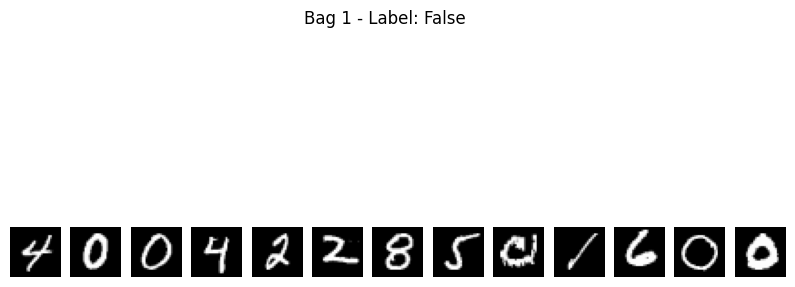

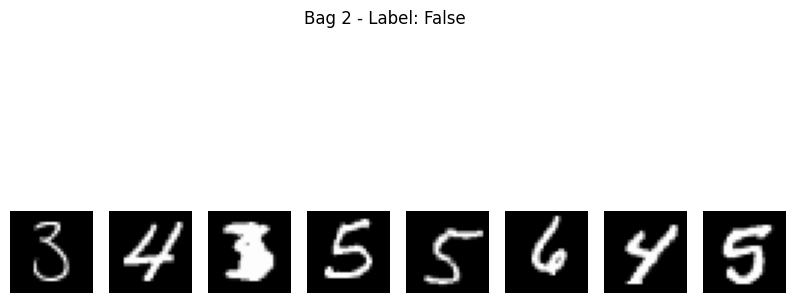

In [4]:
# TODO: Visualize two bags of the dataset with their labels.
# You should:
# 1. Extract two bags and their corresponding labels.
bag1, label1 = train_dataset[0]
bag2, label2 = train_dataset[1]

# 2. Visualize the images in each bag using matplotlib.
# 3. Make sure to include the label in the title of each plot.

# Visualize the first bag
plt.figure(figsize=(10, 5))
for i in range(len(bag1)):
    plt.subplot(1, len(bag1), i+1)
    plt.imshow(bag1[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.suptitle(f"Bag 1 - Label: {label1[0]}")
plt.show()

# Visualize the second bag
plt.figure(figsize=(10, 5))
for i in range(len(bag2)):
    plt.subplot(1, len(bag2), i+1)
    plt.imshow(bag2[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.suptitle(f"Bag 2 - Label: {label2[0]}")
plt.show()

#### Data Loaders
Use DataLoader to get the train and test loaders. Do not change the manual seed that has been set!

In [5]:
# TODO: Load the MNIST_Bags dataset using the DataLoader for both training and testing.
# - Do not delete the torch.manual_seed(1)!
# - Use the following parameters for the training and test sets:
#   - target_number = 9
#   - mean_bag_length = 10
#   - var_bag_length = 2
#   - number_train_items = 300
#   - number_test_items = 100

torch.manual_seed(1)

train_loader = data_utils.DataLoader(
    MNIST_Bags(target_number=9, mean_bag_length=10, var_bag_length=2, num_bag=300, train=True),
    batch_size=1,
    shuffle=True
)


test_loader = data_utils.DataLoader(
    MNIST_Bags(target_number=9, mean_bag_length=10, var_bag_length=2, num_bag=100, train=False),
    batch_size=1,
    shuffle=False
)

### Model

Here we will define our GraphBasedMIL model, complete each funcion based on the comments. An overview of the architecture is here:

<img src="./milgnn_arch.jpg" width="300" style="display:inline-block" />
<img src="./overview_mil_gnn.png" width="300" style="display:inline-block" />


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GraphBasedMIL(nn.Module):
    """
    A neural network class for graph-based Multiple Instance Learning (MIL).
    This model learns to process a bag of instances and predict the class label for the bag.
    """

    def __init__(self):
        """
        Initialize the GraphBasedMIL model with various layers and parameters.

        Outputs:
        - A Graph-based MIL model instance with layers for feature extraction, GNN embedding,
          clustering, and MLP for final classification.
        """
        super(GraphBasedMIL, self).__init__()

        # Define internal model parameters
        self.L = 50  # Dimensionality of node features
        self.C = 1   # Number of clusters
        self.classes = 2  # Number of classes for classification

        self.n = 50  # Threshold for graph edge distance (0 = no edge, inf = fully connected)
        self.n_step = 0.5  # Step increment for the edge distance if not enough edges are created
        self.num_adj_parm = 0.1  # Minimum graph adjacency length to avoid sparse graphs

        self.feature_extractor_part1 = nn.Sequential(
            nn.Conv2d(1, 20, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(20, 50, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
        )

        self.feature_extractor_part2 = nn.Sequential(
            nn.Linear(50 * 4 * 4, self.L),
            nn.ReLU(),
        )

        # Define GNN layers and other parameters
        # self.gnn_embd = None  # Initialize the GNN embedding layer (e.g., DenseSAGEConv)
        self.gnn_embd = DenseSAGEConv(self.L, self.L)
        self.bn1 = nn.BatchNorm1d(self.L)  # Batch normalization layer for GNN embedding

        # self.gnn_pool = None  # Initialize pooling GNN layer (e.g., DenseSAGEConv)
        self.gnn_pool = DenseSAGEConv(self.L, self.C)
        self.bn2 = torch.nn.BatchNorm1d(self.C)
        self.mlp = nn.Linear(self.C, self.C, bias=True)  # Multi-layer perceptron (MLP)

        # self.gnn_embd2 = None  # Second GNN embedding layer (e.g., DenseSAGEConv)
        self.gnn_embd2 = DenseSAGEConv(self.L, self.L)  # Second GNN embedding layer (e.g., DenseSAGEConv)
        self.bn3 = nn.BatchNorm1d(self.L)

        # Final MLP layers for classification
        input_layers = int(self.L * self.C)
        hidden_layers = int(self.L * self.C / 2)
        output_layer = self.classes
        self.lin1 = nn.Linear(input_layers, hidden_layers, bias=True)  # First hidden layer
        self.lin2 = nn.Linear(hidden_layers, output_layer, bias=True)  # Output layer

    def forward(self, x):
        """
        Forward pass of the GraphBasedMIL model.

        Inputs:
        - x (torch.Tensor): Input tensor of shape [batch_size, channels, height, width].

        Outputs:
        - Y_prob (torch.Tensor): Predicted class probabilities.
        - loss (torch.Tensor): Total loss value including auxiliary and main losses.
        """
        # Step 1: Feature extraction (CNN layers)
        # Implement CNN feature extraction here using the layers defined above.
        # You need to extract features from input tensor `x` and reshape them if necessary.
        # Example steps:
        # - Apply CNN layers on x to extract features.
        # - Flatten the feature map.
        # - Pass through a fully connected layer to reduce the feature dimension.

        # H = None  # Replace with actual feature extraction logic
        batch_size, bag_size, channels, height, width = x.shape
        x = x.view(batch_size * bag_size, channels, height, width)
        # x = x.squeeze(0)

        x = self.feature_extractor_part1(x)
        # x = x.view(x.size(0), -1)
        x = x.view(-1, 50 * 4 * 4)
        H = self.feature_extractor_part2(x)

        # Step 2: Create graph adjacency matrix
        # Here, you need to convert the features into graph nodes.
        # Construct the adjacency matrix based on some criteria (e.g., Euclidean distance or similarity).
        # This will require converting the bag of features into a graph structure.
        # Example:
        # - Define the adjacency matrix A.
        # - Define the node features X based on extracted features.
        # X = None  # Replace with graph node features
        # A = torch.ones((len(X), len(X)), device=device)  # Example adjacency
        # X, A = self.convert_bag_to_graph_(H, self.n)
        X = H  # Replace with graph node features
        A = torch.ones((len(X), len(X)), device=device)  # Example adjacency matrix

        # Step 3: GNN Embedding
        # Apply GNN layers to embed the graph node features.
        # For each GNN layer, you will pass the node features X and adjacency matrix A.
        # Z = None  # Replace with actual GNN embedding logic
        # loss_emb_1 = None  # Compute auxiliary loss (based on adjacency and node features)
        # Z = self.gnn_embd(X, A)
        Z = F.leaky_relu(self.gnn_embd(X, A), negative_slope=0.01)
        # Z = self.bn1(Z)
        loss_emb_1 = self.auxiliary_loss(A, Z)

        # Step 4: Clustering
        # Implement clustering using a pooling GNN layer followed by an MLP for the clusters.
        # S = None  # Replace with actual pooling GNN and MLP logic
        # S = F.softmax(self.gnn_pool(Z, A), dim=1)
        # # S = self.bn2(S)
        # S = self.mlp(S)

        S = F.leaky_relu(self.gnn_pool(X, A), negative_slope=0.01)
        # S = F.leaky_relu(self.mlp(S), negative_slope=0.01)
        S = self.mlp(S)

        # Step 5: Coarse-graining the graph using diff pooling
        # Use a diff pooling operation to create a coarsened version of the graph.
        # X, A, l1, e1 = None  # Replace with diff pooling operation
        X, A, l1, e1 = dense_diff_pool(X, A, S)

        # Step 6: Second GNN embedding
        # Apply a second GNN embedding to the coarsened graph.
        # X = None  # Replace with second GNN embedding logic
        # loss_emb_2 = None  # Compute auxiliary loss for the second embedding
        # X = self.gnn_embd2(X, A)
        X = F.leaky_relu(self.gnn_embd2(X, A), negative_slope=0.01)
        # X = self.bn3(X)
        loss_emb_2 = self.auxiliary_loss(A, X)

        # Step 7: Final classification
        # Flatten the final graph node features and pass them through MLP layers for classification.
        X = X.view(1, -1)  # Flatten for the final MLP
        # X = None  # Pass through first MLP layer
        # X = None  # Pass through second MLP layer
        # X = F.relu(self.lin1(X))
        X = F.leaky_relu(self.lin1(X), 0.01)
        X = self.lin2(X)

        # Apply softmax to get probabilities
        # Y_prob = None  # Replace with softmax output
        Y_prob = F.softmax(X, dim=1)

        # Return the predicted probabilities and total loss
        return Y_prob, (l1 + loss_emb_1 + loss_emb_2)

    # GNN methods

    def convert_bag_to_graph_(self, bag, N):
        """
        Converts a bag of instances to a graph, where each instance is a node.

        Inputs:
        - bag (torch.Tensor): Bag of instance features.
        - N (float): Threshold distance for edge creation.

        Outputs:
        - bag (torch.Tensor): Node features for the graph.
        - edge_index (torch.Tensor): Indices of edges between nodes.
        """
        # Implement logic for converting a bag of features into a graph.
        # You can use distance-based criteria (e.g., Euclidean distance) to determine edges.
        edge_index = []
        # chamferDist = None  # Optionally, use Chamfer distance for similarity
        chamferDist = ChamferDistance()

        # Loop over all pairs of nodes (bag) to determine edges
        for cur_i, cur_node in enumerate(bag):
            for alt_i, alt_node in enumerate(bag):
                if cur_i != alt_i and self.euclidean_distance_(cur_node, alt_node) < N:
                    edge_index.append(torch.tensor([cur_i, alt_i]).cuda())  # Add edge if distance is small

        # Ensure enough edges are created
        if len(edge_index) < self.num_adj_parm * bag.shape[0]:
            print(f"INFO: Adjusting edge distance, current number of edges {len(edge_index)}")
            return self.convert_bag_to_graph_(bag, N = (N + self.n_step))  # Retry with adjusted distance

        return bag, torch.stack(edge_index).transpose(1, 0)

        # num_nodes = bag.size(0)
        # edge_index = []
        # chamferDist = ChamferDistance()

        # # Loop over all pairs of nodes (bag) to determine edges
        # for cur_i in range(num_nodes):
        #     for alt_i in range(num_nodes):
        #         if cur_i != alt_i and self.euclidean_distance_(bag[cur_i], bag[alt_i]) < N:
        #             edge_index.append(torch.tensor([cur_i, alt_i]).to(bag.device))  # Add edge if distance is small

        # # Ensure enough edges are created
        # if len(edge_index) < self.num_adj_parm * num_nodes:
        #     print(f"INFO: Adjusting edge distance, current number of edges {len(edge_index)}")
        #     return self.convert_bag_to_graph_(bag, N = (N + self.n_step))  # Retry with adjusted distance

        # # Create the adjacency matrix
        # A = torch.zeros((num_nodes, num_nodes), device=bag.device)
        # for edge in edge_index:
        #     A[edge[0], edge[1]] = 1

        # return bag.unsqueeze(0), A.unsqueeze(0)  # Add batch dimension

    def euclidean_distance_(self, X, Y):
        """
        Compute the Euclidean distance between two vectors.

        Inputs:
        - X (torch.Tensor): First vector.
        - Y (torch.Tensor): Second vector.

        Outputs:
        - dist (torch.Tensor): Euclidean distance between X and Y.
        """
        # Implement Euclidean distance calculation here.
        # Example:
        # dist = sqrt(||X||^2 - 2*X*Y + ||Y||^2)
        # dist = None  # Compute Euclidean distance
        dist = torch.sqrt(torch.sum((X - Y) ** 2))
        return dist

    def auxiliary_loss(self, A, S):
        """
        Computes the auxiliary loss for graph structure regularization.

        Inputs:
        - A (torch.Tensor): Adjacency matrix of the graph.
        - S (torch.Tensor): Node features (softmax probabilities).

        Outputs:
        - link_loss (torch.Tensor): Computed loss based on adjacency and node features.
        """
        # Implement loss calculation that measures how well the adjacency matches with the node features.
        # link_loss = None  # Replace with actual link loss calculation
        S = S.unsqueeze(0) if S.dim() == 2 else S
        A = A.unsqueeze(0) if A.dim() == 2 else A

        S = torch.softmax(S, dim=-1)

        # link_loss = torch.mean((A - torch.matmul(S, S.transpose(1, 2))) ** 2)
        link_loss = torch.norm((A - torch.matmul(S, S.transpose(1, 2))), p=2)
        return link_loss / A.numel()

    def calculate_classification_error(self, output, target, TP, TN, FP, FN):
        """
        Calculate the classification error metrics (True Positive, True Negative, False Positive, False Negative).

        Inputs:
        - output (torch.Tensor): The predicted class probabilities (e.g., from softmax).
        - target (torch.Tensor): The ground truth labels.
        - TP (list): True Positives count (mutable).
        - TN (list): True Negatives count (mutable).
        - FP (list): False Positives count (mutable).
        - FN (list): False Negatives count (mutable).

        Outputs:
        - Updates TP, TN, FP, FN based on the predicted and target labels.

        Instructions:
        - Implement the logic to find the predicted class using `torch.argmax(output)` (for binary classification).
        - Compare the prediction with the target:
            - If the prediction and target both equal 1, increment TP.
            - If the prediction is 1 and the target is 0, increment FP.
            - If the prediction is 0 and the target is 1, increment FN.
            - If both prediction and target are 0, increment TN.
        """
        # Your implementation here
        # pass
        predicted = torch.argmax(output, dim=1)
        for p, t in zip(predicted, target):
            if p == 1 and t == 1:
                TP.append(1)
            elif p == 1 and t == 0:
                FP.append(1)
            elif p == 0 and t == 1:
                FN.append(1)
            elif p == 0 and t == 0:
                TN.append(1)


    def cross_entropy_loss(self, output, target):
        """
        Calculate the cross-entropy loss for the classification task.

        Inputs:
        - output (torch.Tensor): Model output (raw logits or probabilities).
        - target (torch.Tensor or list): Ground truth labels (should be in long type for classification).

        Outputs:
        - l1 (torch.Tensor): Cross-entropy loss.

        Instructions:
        - If `output` has only one dimension, add an extra dimension to match the expected input format.
        - Convert `target` to a tensor of type `long` and move to the GPU if necessary.
        - Use the built-in `CrossEntropyLoss` from PyTorch to compute the loss.
        - Return the computed cross-entropy loss.
        """
        # Your implementation here
        # pass
        if output.dim() == 1:
            output = output.unsqueeze(0)
        target = torch.tensor(target, dtype=torch.long).cuda()
        criterion = nn.CrossEntropyLoss()
        l1 = criterion(output, target)
        return l1


    def calculate_objective(self, X, target):
        """
        Calculate the objective function that combines the likelihood loss and any regularization terms.

        Inputs:
        - X (torch.Tensor): Input features or data used for forward pass.
        - target (torch.Tensor or list): Ground truth labels.

        Outputs:
        - neg_log_likelihood (float): The negative log-likelihood (log loss).

        Instructions:
        - Convert the `target` to float type for compatibility with the computation.
        - Pass the input `X` through the forward pass to get predicted probabilities (`Y_prob`) and auxiliary loss (`l1`).
        - Clamp the predicted probabilities (`Y_prob`) to prevent log(0) errors.
        - Compute the negative log-likelihood using the target labels and predicted probabilities.
        - Return the computed negative log-likelihood.
        """
        # Your implementation here
        # pass
        target = target.float()
        Y_prob, l = self.forward(X)
        Y_prob = torch.clamp(Y_prob, min=1e-5, max=1.0 - 1e-5)
        neg_log_likelihood = -torch.mean(target * torch.log(Y_prob[:, 1]) + (1 - target) * torch.log(Y_prob[:, 0]))
        return neg_log_likelihood

### Training
Train your model for 100 epochs.

In [7]:
def train(model, optimizer, train_loader):
    """
    Train the model for one epoch.

    Inputs:
    - model: The model to train.
    - optimizer: The optimizer to use for gradient descent.
    - train_loader: DataLoader object that provides batches of training data.

    Outputs:
    - train_loss (float): Average training loss for the epoch.
    - Accuracy (float): Accuracy of the model on the training set.
    - Precision (float): Precision of the model on the training set.
    - Recall (float): Recall of the model on the training set.
    - F1 (float): F1 score of the model on the training set.

    Instructions:
    - Set the model to training mode using `model.train()`.
    - Initialize variables to track loss and metrics: `train_loss`, `TP`, `TN`, `FP`, `FN`, and `ALL`.
    - Loop over batches of data in `train_loader`:
        - Get `data` (input) and `label` (ground truth).
        - Move data and label to GPU if available (`data.cuda()`, `target.cuda()`).
        - Zero the gradients using `optimizer.zero_grad()` every `batch` iterations.
        - Pass the data through the model (`output, l = model(data)`).
        - Compute the cross-entropy loss using `model.cross_entropy_loss(output, target)` and add any auxiliary loss `l`.
        - Use `model.calculate_classification_error(output, target, TP, TN, FP, FN)` to update classification metrics.
        - Update the total `train_loss`.
        - Perform backpropagation and optimization (`loss.backward()` and `optimizer.step()`) every `batch` iterations.
    - Compute final metrics:
        - **Accuracy**: (TP + TN) / total samples.
        - **Precision**: TP / (TP + FP) (Handle division by zero).
        - **Recall**: TP / (TP + FN) (Handle division by zero).
        - **F1 score**: Harmonic mean of Precision and Recall (Handle division by zero).
    - Return `train_loss`, `Accuracy`, `Precision`, `Recall`, and `F1`.
    """
    # Your implementation here
    # pass
    model.train()
    train_loss = 0
    TP, TN, FP, FN, ALL = [], [], [], [], []

    for data, target in train_loader:
        data, target = data.to(device), target[0].to(device)
        optimizer.zero_grad()
        output, l = model(data)
        loss = model.cross_entropy_loss(output, target) + l
        model.calculate_classification_error(output, target, TP, TN, FP, FN)
        ALL.append(1)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    Accuracy = (len(TP) + len(TN)) / len(ALL)
    Precision = len(TP) / (len(TP) + len(FP)) if (len(TP) + len(FP)) > 0 else 0
    Recall = len(TP) / (len(TP) + len(FN)) if (len(TP) + len(FN)) > 0 else 0
    F1 = 2 * Precision * Recall / (Precision + Recall) if (Precision + Recall) > 0 else 0

    return train_loss / len(train_loader), Accuracy, Precision, Recall, F1


def test(model, test_loader):
    """
    Evaluate the model on the test set.

    Inputs:
    - model: The trained model to evaluate.
    - test_loader: DataLoader object that provides batches of test data.

    Outputs:
    - Accuracy (float): Accuracy of the model on the test set.
    - Precision (float): Precision of the model on the test set.
    - Recall (float): Recall of the model on the test set.
    - F1 (float): F1 score of the model on the test set.

    Instructions:
    - Set the model to evaluation mode using `model.eval()`.
    - Initialize variables to track metrics: `TP`, `TN`, `FP`, `FN`, and `ALL`.
    - Loop over batches of data in `test_loader`:
        - Get `data` (input) and `label` (ground truth).
        - Move data and label to GPU if available (`data.cuda()`, `target.cuda()`).
        - Pass the data through the model (`output, _ = model(data)`).
        - Use `model.calculate_classification_error(output, target, TP, TN, FP, FN)` to update classification metrics.
    - Compute final metrics:
        - **Accuracy**: (TP + TN) / total samples.
        - **Precision**: TP / (TP + FP) (Handle division by zero).
        - **Recall**: TP / (TP + FN) (Handle division by zero).
        - **F1 score**: Harmonic mean of Precision and Recall (Handle division by zero).
    - Return `Accuracy`, `Precision`, `Recall`, and `F1`.
    """
    # Your implementation here
    # pass
    model.eval()
    TP, TN, FP, FN, ALL = [], [], [], [], []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target[0].to(device)
            output, _ = model(data)
            model.calculate_classification_error(output, target, TP, TN, FP, FN)
            ALL.append(1)

    Accuracy = (len(TP) + len(TN)) / len(ALL)
    Precision = len(TP) / (len(TP) + len(FP)) if (len(TP) + len(FP)) > 0 else 0
    Recall = len(TP) / (len(TP) + len(FN)) if (len(TP) + len(FN)) > 0 else 0
    F1 = 2 * Precision * Recall / (Precision + Recall) if (Precision + Recall) > 0 else 0

    return Accuracy, Precision, Recall, F1

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GraphBasedMIL().cuda()
# optimizer = optim.Adam(model.parameters(), lr=3e-6, betas=(0.9, 0.999), weight_decay=1e-3)
optimizer = optim.Adam(model.parameters(), lr=9e-7, betas=(0.9, 0.999), weight_decay=1e-3)

In [9]:
# Lists to store metrics for each epoch
train_precision = []
train_recall = []
train_f1 = []

test_precision = []
test_recall = []
test_f1 = []

epochs_n = 30  # Total number of epochs to train the model

for epoch in range(epochs_n):
    # Call the train function to get training metrics
    # Save precision, recall, F1, and other metrics for training
    # Call the test function to get testing metrics
    # Save precision, recall, F1, and other metrics for testing

    # Save the metrics to the lists

    # Print metrics after each epoch

    train_loss, train_acc, train_prec, train_rec, train_f1_score = train(model, optimizer, train_loader)
    test_acc, test_prec, test_rec, test_f1_score = test(model, test_loader)

    train_precision.append(train_prec)
    train_recall.append(train_rec)
    train_f1.append(train_f1_score)
    test_precision.append(test_prec)
    test_recall.append(test_rec)
    test_f1.append(test_f1_score)

    print(f'Epoch {epoch+1}/{epochs_n}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train Prec: {train_prec:.4f}, Train Rec: {train_rec:.4f}, Train F1: {train_f1_score:.4f}, Test Acc: {test_acc:.4f}, Test Prec: {test_prec:.4f}, Test Rec: {test_rec:.4f}, Test F1: {test_f1_score:.4f}')

<ipython-input-6-2c7e8d8431f5>:311: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target, dtype=torch.long).cuda()


Epoch 1/30, Train Loss: 94.5388, Train Acc: 0.4900, Train Prec: 0.5967, Train Rec: 0.5745, Train F1: 0.5854, Test Acc: 0.4500, Test Prec: 0.5682, Test Rec: 0.4098, Test F1: 0.4762
Epoch 2/30, Train Loss: 94.2246, Train Acc: 0.3767, Train Prec: 0.5102, Train Rec: 0.1330, Train F1: 0.2110, Test Acc: 0.3700, Test Prec: 0.2500, Test Rec: 0.0164, Test F1: 0.0308
Epoch 3/30, Train Loss: 93.8186, Train Acc: 0.3667, Train Prec: 0.0000, Train Rec: 0.0000, Train F1: 0.0000, Test Acc: 0.4000, Test Prec: 1.0000, Test Rec: 0.0164, Test F1: 0.0323
Epoch 4/30, Train Loss: 93.7112, Train Acc: 0.3667, Train Prec: 0.2500, Train Rec: 0.0053, Train F1: 0.0104, Test Acc: 0.4000, Test Prec: 1.0000, Test Rec: 0.0164, Test F1: 0.0323
Epoch 5/30, Train Loss: 93.6711, Train Acc: 0.3833, Train Prec: 0.5429, Train Rec: 0.1011, Train F1: 0.1704, Test Acc: 0.3900, Test Prec: 0.5000, Test Rec: 0.1967, Test F1: 0.2824
Epoch 6/30, Train Loss: 93.6465, Train Acc: 0.5233, Train Prec: 0.6286, Train Rec: 0.5851, Train F1:

### Results
Plot the F1, Precision, Recall of both train and test sets over the 100 epochs.

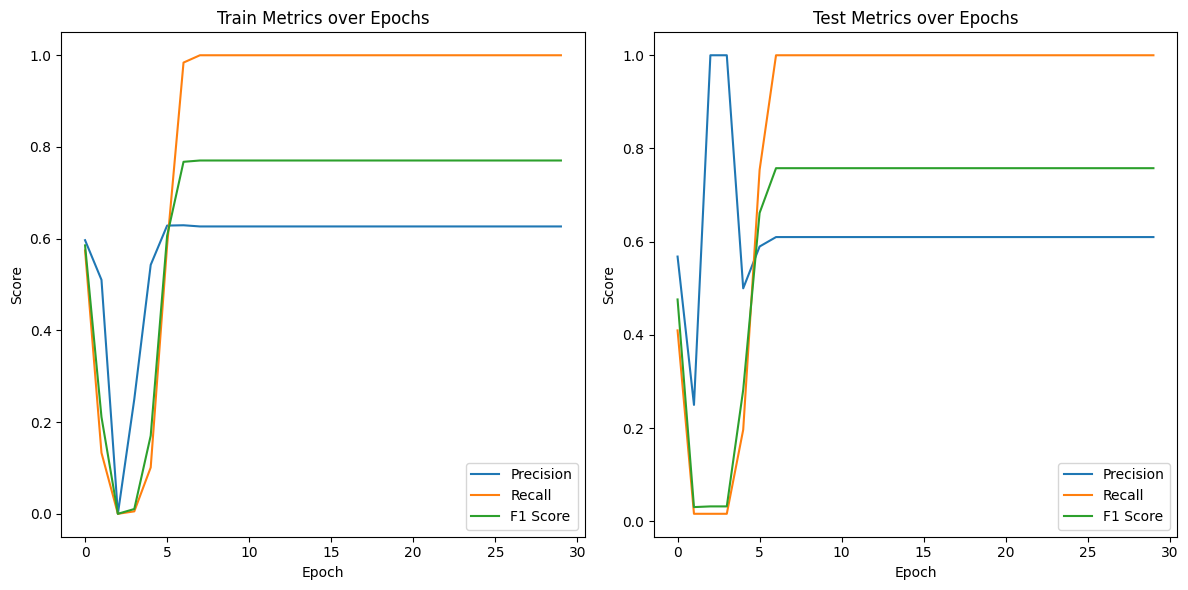

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot Precision, Recall, F1 for Train
# You need to plot the Precision, Recall, and F1 score for the training set
plt.subplot(1, 2, 1)
plt.plot(train_precision, label='Precision')
plt.plot(train_recall, label='Recall')
plt.plot(train_f1, label='F1 Score')
plt.title('Train Metrics over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()

# Plot the test metrics
# Plot the Precision, Recall, and F1 score for the test set
plt.subplot(1, 2, 2)
plt.plot(test_precision, label='Precision')
plt.plot(test_recall, label='Recall')
plt.plot(test_f1, label='F1 Score')
plt.title('Test Metrics over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()

plt.tight_layout()
plt.show()